#  El Problema

Vamos a utilizar los datos de la competición de predicción de los datos del Dengue. Mas información en [enlace](https://www.drivendata.org/competitions/44/dengai-predicting-disease-spread/)

El objetivo del ejercicio es por un lado jugar con una red neuronal para resolver un problema de regresión y por otro participar en una competición de datos. 


# Setting Preliminares

Antes de empezar cualquier análisis hay que asegurar que las librerías básicas y de uso general (numpy, pandas, etc.) están correctamente importadas. 

In [ ]:
# carga de datos
import pandas as pd
import io
from google.colab import files
# manipulación y visualización
import matplotlib.pyplot as plt
import numpy as np
import itertools
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
import numpy as np

from sklearn.cluster import KMeans #importando kmeans para usar los clusters




# Carga de Datos

En primer lugar cargamos los datos dentro del entorno con las funcionalidades que nos permite Google Colab

In [ ]:
def upload_files (index_fields):
  uploaded = files.upload()
  for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))
    df = pd.read_csv(io.StringIO(uploaded[fn].decode('utf-8')), index_col = index_fields)
    return df

En primer lugar subimos los datos de entrenamiento sin campo objetivo (dengue_features_train) (Podemos subir el archivo .cvs al apartado de files en Google Colab para despues leer el archivo


In [ ]:
train = pd.read_csv("dengue_features_train.csv")
train.head()

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,sj,1990,18,30/04/1990,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,...,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0
1,sj,1990,19,7/05/1990,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,...,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6
2,sj,1990,20,14/05/1990,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,...,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4
3,sj,1990,21,21/05/1990,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,...,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0
4,sj,1990,22,28/05/1990,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,...,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8


Con la funcion shape podemos apreciar cuantos registros hay en nuestro archivo 1456 y tambien cuantas caracteristicas tiene 24

In [ ]:
train.shape

(1456, 24)

# Preproceso

En la etapa de preproceso estan todas las funciones y transformaciones que permitieran el uso de las variables en los siguientes clasificadores, por ejemplo algunas caracteristicas deben ser eliminadas de nuestro dataset para manejar solamente las caracteristicas numericas si queremos usar todas ellas las que han sido eliminadas son: week_start_date, city, year, weekofyear.

In [ ]:
train.drop(['week_start_date'], axis= 1, inplace = True)
train.drop(["city"], axis = 1, inplace = True)
train.drop(["year"], axis = 1, inplace = True)
train.drop(["weekofyear"], axis = 1, inplace = True)
train.head()


,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,292.414286,299.8,295.9,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0
1,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,293.951429,300.9,296.4,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6
2,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,295.434286,300.5,297.3,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4
3,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,295.310000,301.4,297.0,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0
4,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,295.821429,301.9,297.5,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8


Trataremos los valores perdidos que los hay dado que nos evitarían tener un modelo de los datos que tenemos.

In [ ]:
train.isnull().sum()

ndvi_ne                                  194
ndvi_nw                                   52
ndvi_se                                   22
ndvi_sw                                   22
precipitation_amt_mm                      13
reanalysis_air_temp_k                     10
reanalysis_avg_temp_k                     10
reanalysis_dew_point_temp_k               10
reanalysis_max_air_temp_k                 10
reanalysis_min_air_temp_k                 10
reanalysis_precip_amt_kg_per_m2           10
reanalysis_relative_humidity_percent      10
reanalysis_sat_precip_amt_mm              13
reanalysis_specific_humidity_g_per_kg     10
reanalysis_tdtr_k                         10
station_avg_temp_c                        43
station_diur_temp_rng_c                   43
station_max_temp_c                        20
station_min_temp_c                        14
station_precip_mm                         22
dtype: int64

In [ ]:
pd.isnull(train).any()

ndvi_ne                                  True
ndvi_nw                                  True
ndvi_se                                  True
ndvi_sw                                  True
precipitation_amt_mm                     True
reanalysis_air_temp_k                    True
reanalysis_avg_temp_k                    True
reanalysis_dew_point_temp_k              True
reanalysis_max_air_temp_k                True
reanalysis_min_air_temp_k                True
reanalysis_precip_amt_kg_per_m2          True
reanalysis_relative_humidity_percent     True
reanalysis_sat_precip_amt_mm             True
reanalysis_specific_humidity_g_per_kg    True
reanalysis_tdtr_k                        True
station_avg_temp_c                       True
station_diur_temp_rng_c                  True
station_max_temp_c                       True
station_min_temp_c                       True
station_precip_mm                        True
dtype: bool

Los vamos a procesar de forma automática completandolos con el método ffill (con el valor previo)

In [ ]:
# ffill: propagate last valid observation forward to next valid backfill
train.fillna(method='ffill', inplace=True)
pd.isnull(train).any()

ndvi_ne                                  False
ndvi_nw                                  False
ndvi_se                                  False
ndvi_sw                                  False
precipitation_amt_mm                     False
reanalysis_air_temp_k                    False
reanalysis_avg_temp_k                    False
reanalysis_dew_point_temp_k              False
reanalysis_max_air_temp_k                False
reanalysis_min_air_temp_k                False
reanalysis_precip_amt_kg_per_m2          False
reanalysis_relative_humidity_percent     False
reanalysis_sat_precip_amt_mm             False
reanalysis_specific_humidity_g_per_kg    False
reanalysis_tdtr_k                        False
station_avg_temp_c                       False
station_diur_temp_rng_c                  False
station_max_temp_c                       False
station_min_temp_c                       False
station_precip_mm                        False
dtype: bool

Hay que seleccionar características, pueden ser todas, pero eso normalmente no es una buena idea, por lo que aquí dejaremos algunas seleccionadas.

In [ ]:
selected_features = ['reanalysis_specific_humidity_g_per_kg', 'reanalysis_dew_point_temp_k', 
                 'station_avg_temp_c', 'precipitation_amt_mm', 'station_min_temp_c', 'reanalysis_precip_amt_kg_per_m2','station_precip_mm']

Normalizamos los datos a partir de los coeficientes mínimo y máximo de la colección de entrenamiento, en el siguiente codigo hemos transformado todas las variables del dataset en la misma escala para que ninguna tenga mas peso que otra.

In [ ]:
from sklearn.preprocessing import MinMaxScaler
# performin min-max scaling each continuous feature column to the range [0, 1]
scaler = MinMaxScaler()
X_train = scaler.fit_transform(train[selected_features])
X_train

array([[0.26265926, 0.31467964, 0.43009119, ..., 0.48623853, 0.05609115,
        0.02944966],
       [0.418164  , 0.48921331, 0.56534954, ..., 0.68807339, 0.0314461 ,
        0.01582919],
       [0.58689971, 0.65758313, 0.56534954, ..., 0.74311927, 0.04574934,
        0.07620099],
       ...,
       [0.60519438, 0.66520682, 0.31914894, ..., 0.41284404, 0.08869413,
        0.01362047],
       [0.58314276, 0.64509327, 0.42907801, ..., 0.57798165, 0.10925504,
        0.02944966],
       [0.64488729, 0.6999189 , 0.6462766 , ..., 0.68807339, 0.06468011,
        0.03754832]])

Comprobamos que el valor maximo sea 1

In [ ]:
X_train.max(axis=0)

array([1., 1., 1., 1., 1., 1., 1.])

Comprobamos que el valor minimo sea 0

In [ ]:
X_train.min(axis=0)

array([0., 0., 0., 0., 0., 0., 0.])

Dibujamos el Dendograma con el metodo complete que hace alucion a la media ... (completar)

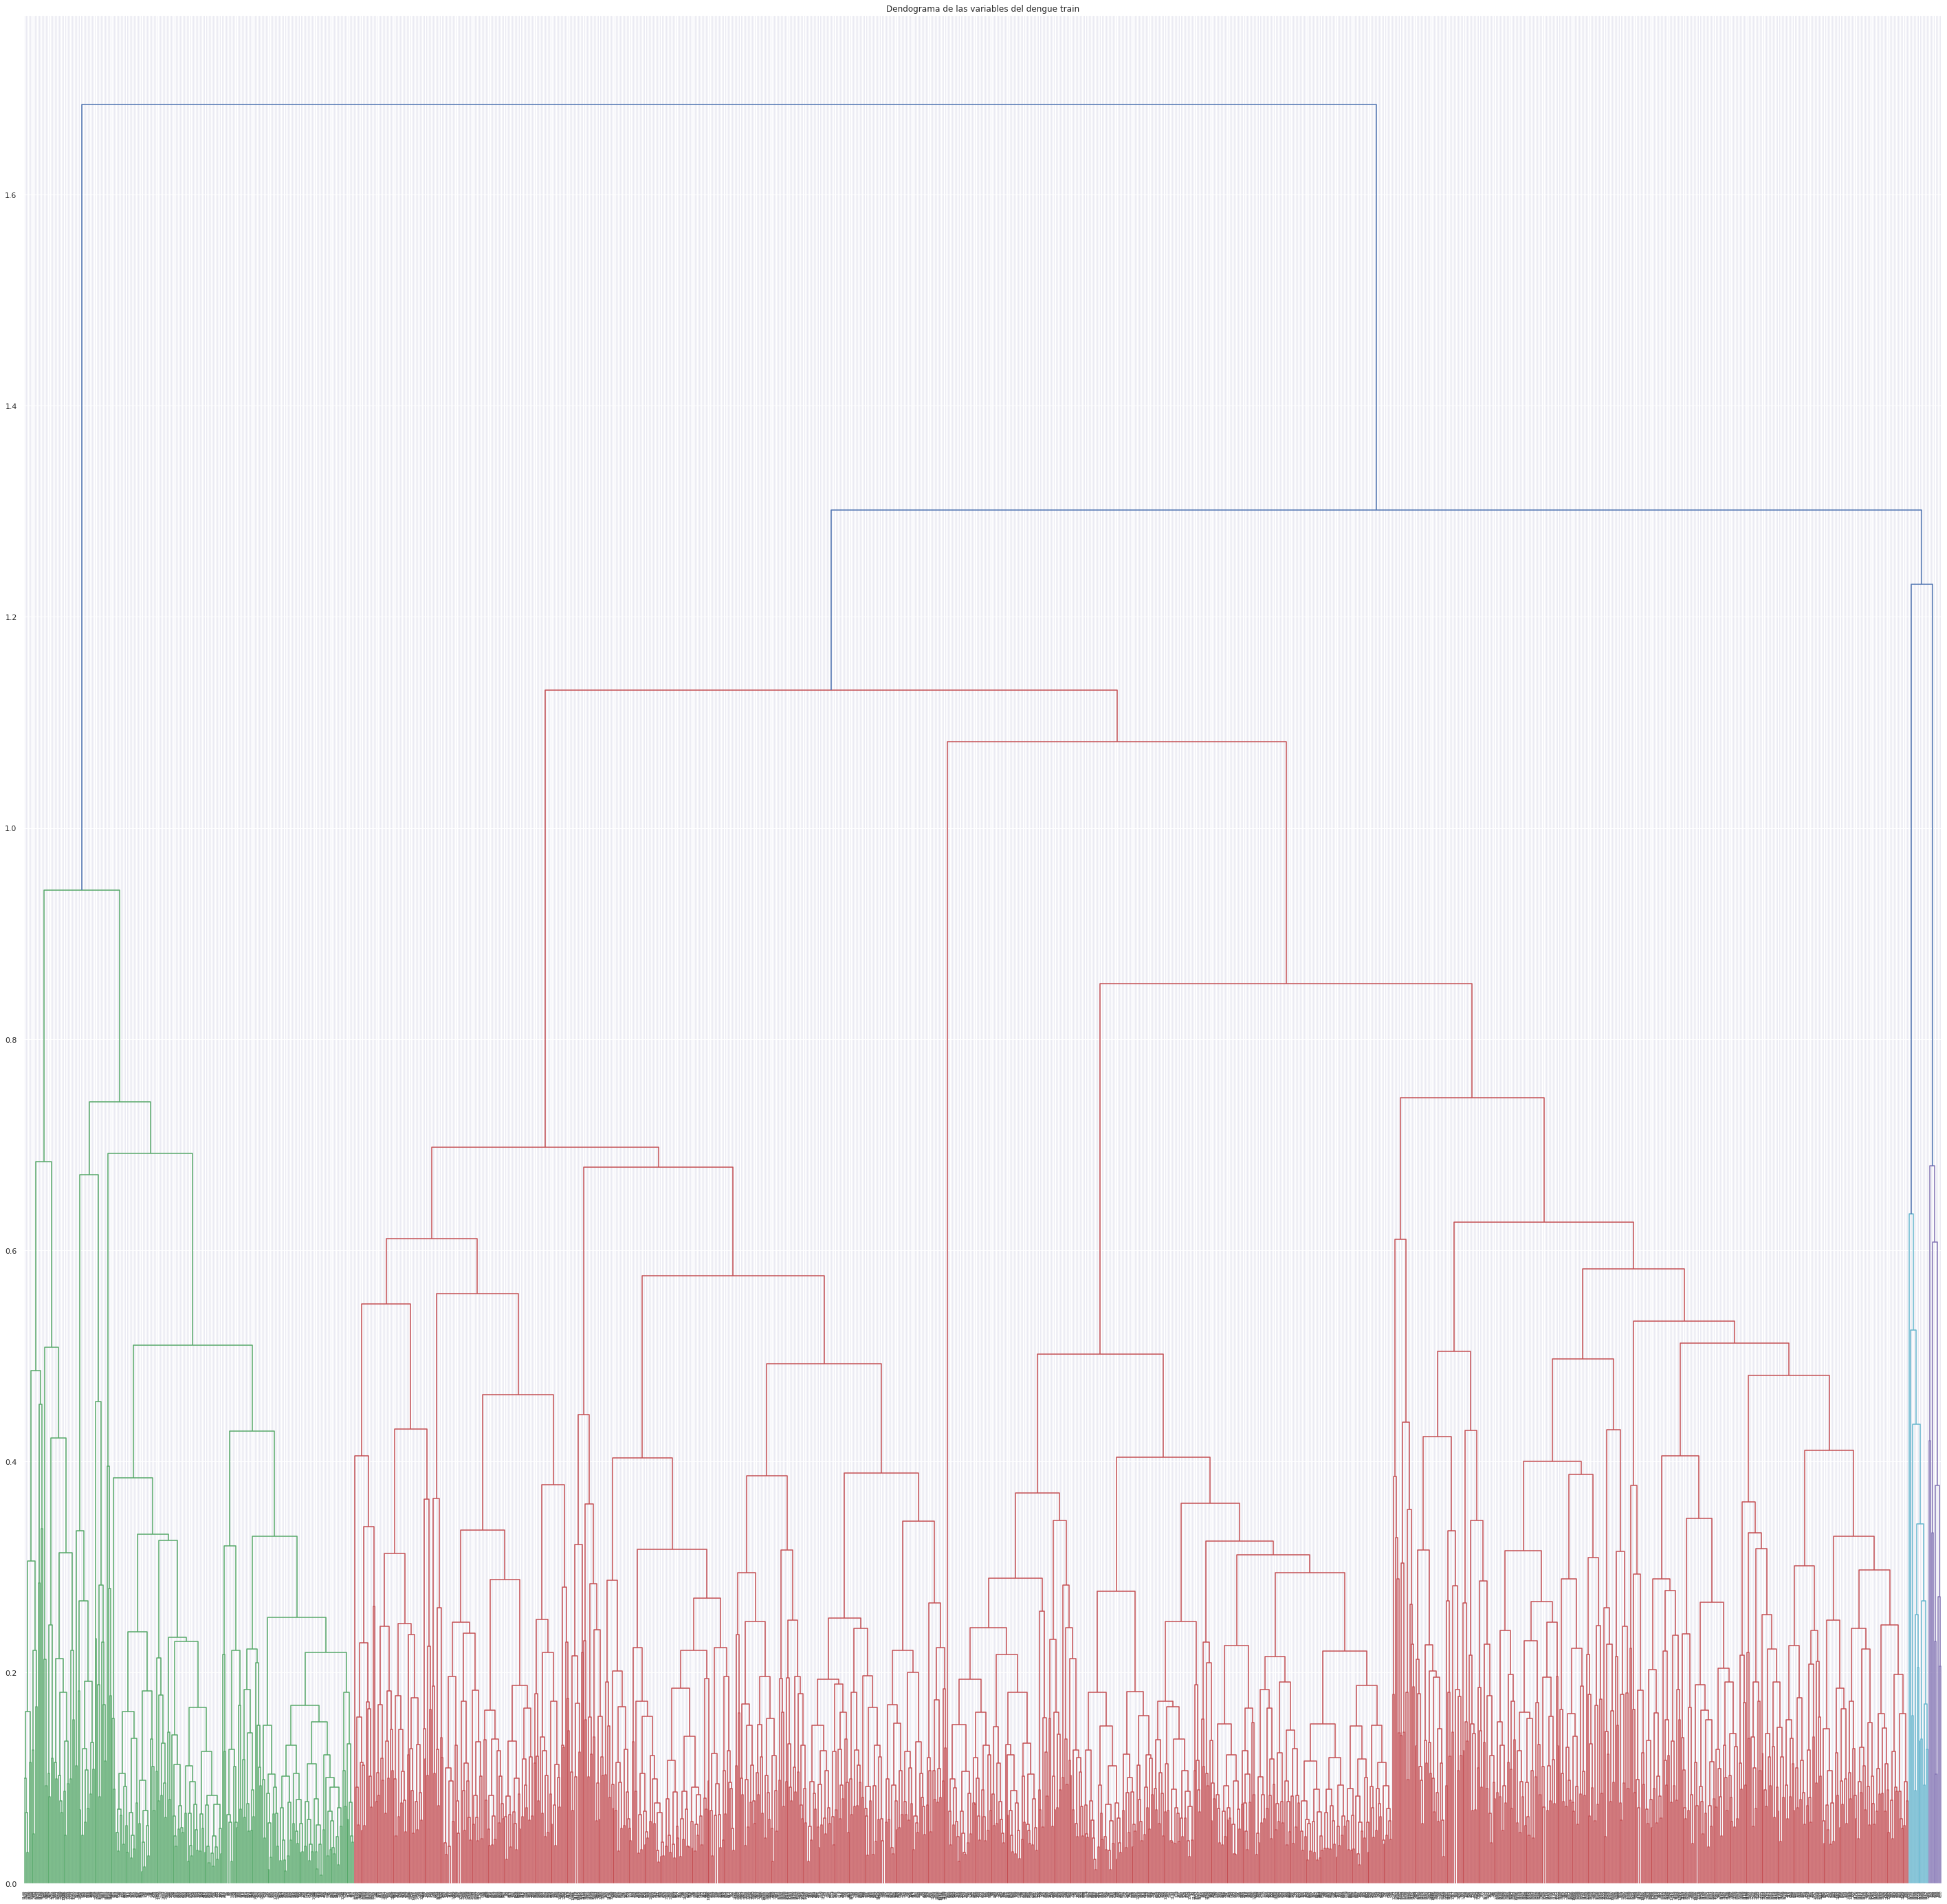

In [ ]:
plt.figure(figsize=(50, 50))
plt.title("Dendograma de las variables del dengue train")
Z = linkage(X_train, method='complete') 
dendograma = dendrogram(Z)

Como se puede analizar en el diagrama del Dendograma si se realiza un corte en 1.3 hay 3 clusters el primero en color verde, el siguiente en color rojo que abarca gran mayoria de los registros y por ultimo los grupos de color magenta y violeta se unen cuando la distancia va acercandose al numero de corte que hemos seleccionado de 1.3

Ahora vamos a analisar nuestros datos mediante el clustering aglomerativo, y hacemos la grafica nuestros registros y a que cluster corresponden.

[2 4 1 ... 4 4 1]
[[0.26265926 0.31467964 0.43009119 ... 0.48623853 0.05609115 0.02944966]
 [0.418164   0.48921331 0.56534954 ... 0.68807339 0.0314461  0.01582919]
 [0.58689971 0.65758313 0.56534954 ... 0.74311927 0.04574934 0.07620099]
 ...
 [0.60519438 0.66520682 0.31914894 ... 0.41284404 0.08869413 0.01362047]
 [0.58314276 0.64509327 0.42907801 ... 0.57798165 0.10925504 0.02944966]
 [0.64488729 0.6999189  0.6462766  ... 0.68807339 0.06468011 0.03754832]]


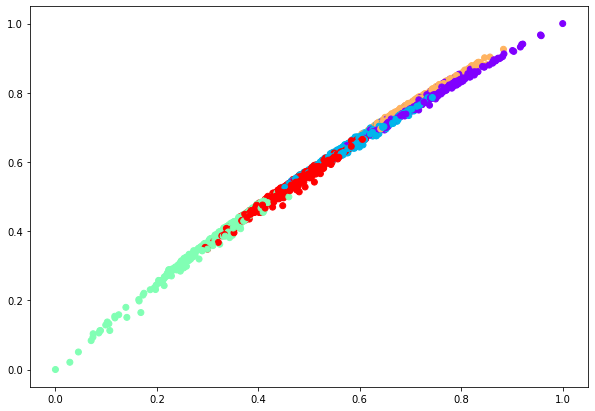

In [ ]:
from sklearn.cluster import AgglomerativeClustering

cluster = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='ward')
clusters = cluster.fit_predict(X_train)
print(clusters)
print(X_train)
plt.figure(figsize=(10, 7))
plt.scatter(X_train[:,0], X_train[:,1], c=cluster.labels_, cmap='rainbow')

Se ha graficado el clustering aglomerativo con 5 clusters teniendo en cuenta el dendograma anterior, affinity es euclidean y al seleccionar este tipo de afinidad por defecto debemos usar 'ward', como observacion se encuentra que los datos se encuentran superpuestos unos de otros y es un poco complicado establecer los limites en los diferentes clusterings 

**Mapa de Calor** Mediante la funcionalidad clustermap, se puede apreciar como hay diferentes clusters en el mapa de calor y como este esta enlazado con los diferentes grupos en el dendograma .... (Extender la explicacion)

/usr/local/lib/python3.7/dist-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


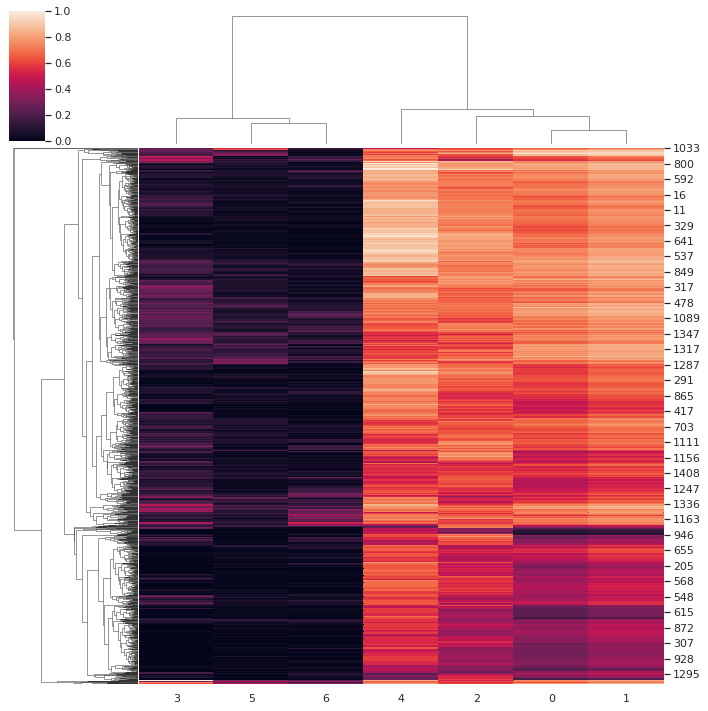

In [ ]:
sns.set(color_codes=True)
sns.clustermap(X_train, standard_scale=1)

**K-means** 

Version 1.0 siguiendo este video https://www.youtube.com/watch?v=SrY0sTJchHE en primera instancia hemos encontrado el valor de K-means para el numero de clusters mediante el metodo del codo.

Encontrando el WCSS para el numero de clusters

In [ ]:
#encontrando el wcss value for different number of clusters
wcss = []
for i in range(1,11):
  kmeans = KMeans(n_clusters=i, init="k-means++", random_state=42)
  kmeans.fit(X_train)
  wcss.append(kmeans.inertia_)



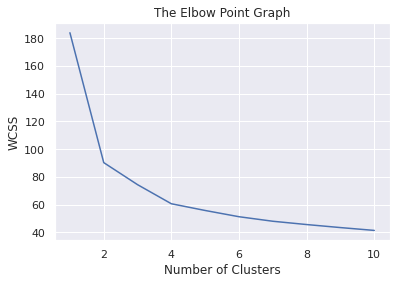

In [ ]:
#plot elbow 
sns.set()
plt.plot(range(1,11), wcss)
plt.title("The Elbow Point Graph")
plt.xlabel("Number of Clusters")
plt.ylabel("WCSS")
plt.show()

Con el grafico del codo hemos encontrado que el numero de cluster debe ser 4 ya que despues de ese valor no hay un decrecimiento tan marcado

***Entrenamiento del Modelo k-Means Clustering***  

In [ ]:
kmeans = KMeans(n_clusters=4, init='k-means++', random_state=0)

#regresar una etiqueta por cada punto de data basado en el cluster
Y = kmeans.fit_predict(X_train)
print(Y)

[2 1 1 ... 1 1 0]


Ahora vamos a visualizar los clusters

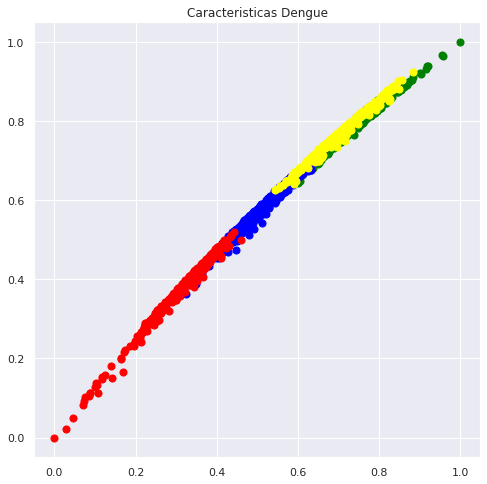

In [ ]:
plt.figure(figsize=(8,8))
plt.scatter(X_train[Y==0,0], X_train[Y==0,1], s=50, c="green", label="Cluster 1")
plt.scatter(X_train[Y==1,0], X_train[Y==1,1], s=50, c="blue", label="Cluster 2")
plt.scatter(X_train[Y==2,0], X_train[Y==2,1], s=50, c="red", label="Cluster 3")
plt.scatter(X_train[Y==3,0], X_train[Y==3,1], s=50, c="yellow", label="Cluster 4")

#dibujar los centroides
#plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], s=100, c="cyan", label="centroids")
plt.title("Caracteristicas Dengue")
plt.show()

Visualizando los clusters con el modelo K-means se puede apreciar a grandes rasgos los 4 clusters de nuestros datos

K-Means Version 2.0 https://www.youtube.com/watch?v=s6PSSzeUMFk siguiendo este video en youtube llegue a este resultado

In [ ]:
clustering = KMeans(n_clusters = 4, max_iter = 300)
clustering.fit(X_train)

KMeans(n_clusters=4)

Hemos agregado una columna al dataframe con el nombre de Kmeans_clusters donde vemos a que cluster equivale cada record.

In [ ]:
train["KMeans_Clusters"] = clustering.labels_
train.head()

,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,KMeans_Clusters
0,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,292.414286,299.8,295.9,...,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,0
1,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,293.951429,300.9,296.4,...,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,2
2,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,295.434286,300.5,297.3,...,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,2
3,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,295.310000,301.4,297.0,...,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,2
4,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,295.821429,301.9,297.5,...,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,3


Analisis de Componentes principales para reducer la dimensionailidad de nuestros datos pasando de 20 caracteristicas a 2 componentes y ser capaces de graficar y tener una mejor visualizacion de como se formaron los clusters, nuevamente hemos agregado una columna al final para ver a que cluster equivale cada registro.

In [ ]:
from sklearn.decomposition import PCA
import pandas as pd
pca = PCA(n_components=2)
pca_train = pca.fit_transform(X_train)
pca_train_d = pd.DataFrame(data = pca_train, columns = ["Componente_1","Componente_2"])
pca_nombres_train = pd.concat([pca_train_d, train[["KMeans_Clusters"]]], axis=1)

pca_nombres_train

,Componente_1,Componente_2,KMeans_Clusters
0,0.528412,0.010392,0
1,0.211109,-0.095925,2
2,-0.016332,-0.042337,2
3,-0.027768,-0.155186,2
4,-0.173118,-0.222659,3
...,...,...,...
1451,-0.293032,-0.003466,3
1452,-0.214229,0.195285,1
1453,0.169499,0.228718,2
1454,0.089527,0.119465,2


Graficamos el K-means de los componentes 1, 2 con los 4 clusters asignados anteriormente.

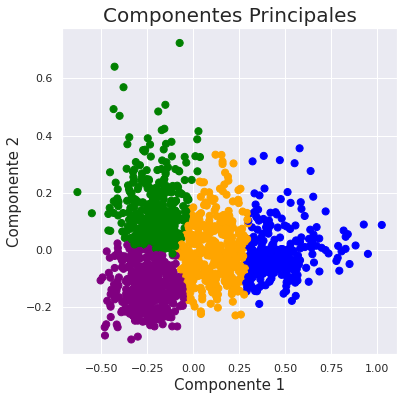

In [ ]:
fig = plt.figure(figsize = (6,6))

ax = fig.add_subplot(1,1,1)
ax.set_xlabel('Componente 1', fontsize = 15)
ax.set_ylabel('Componente 2', fontsize = 15)
ax.set_title('Componentes Principales', fontsize = 20)

color_theme = np.array(['blue','green','orange','purple'])
ax.scatter(x=pca_nombres_train.Componente_1,
           y=pca_nombres_train.Componente_2, 
           c=color_theme[pca_nombres_train.KMeans_Clusters], s = 50)

plt.show()



DBSCAN

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(train[selected_features])

print(X_scaled)

[[-1.7724755  -1.85406387 -1.35694108 ... -1.33870766 -0.18727386
  -0.48987568]
 [-0.89035905 -0.847423   -0.36396382 ...  0.06383973 -0.51187804
  -0.64616845]
 [ 0.06681142  0.1236673  -0.36396382 ...  0.44635265 -0.32348756
   0.04658872]
 ...
 [ 0.17058983  0.1676377  -2.17140557 ... -1.8487249   0.24214561
  -0.67151323]
 [ 0.04549979  0.05163074 -1.36437911 ... -0.70118612  0.51295691
  -0.48987568]
 [ 0.39575191  0.36784323  0.23014898 ...  0.06383973 -0.07414723
  -0.39694484]]


In [ ]:
from sklearn.decomposition import PCA
import pandas as pd
pcaDb = PCA(n_components=2)
pca_trainDb = pcaDb.fit_transform(X_scaled)
pca_train_dDB = pd.DataFrame(data = pca_trainDb, columns = ["Componente_1","Componente_2"])
print(pca_train_dDB)

      Componente_1  Componente_2
0         3.221577      0.607491
1         1.422488     -0.583541
2         0.055004     -0.331959
3         0.158997     -1.392338
4        -0.731928     -2.051108
...            ...           ...
1451     -1.668571     -0.606901
1452     -2.165230      1.985779
1453      1.336172      1.320382
1454      0.609753      0.820783
1455     -0.525203     -0.224547

[1456 rows x 2 columns]


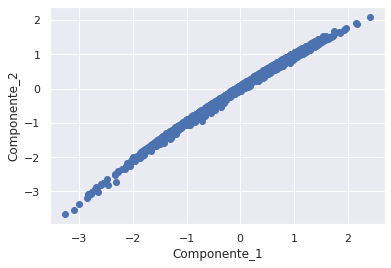

In [ ]:
plt.scatter(X_scaled[:, 0], X_scaled[:, 1])
plt.xlabel("Componente_1")
plt.ylabel("Componente_2")
plt.show()

Vamos a ver, lo primero, como se comportaría el K-means con este conjunto de datos que a priori no parece demasiado complicado.

Text(0, 0.5, 'Componente_2')

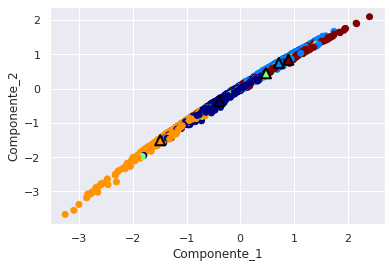

In [ ]:
kmeans = KMeans(n_clusters=5)
y_pred = kmeans.fit_predict(X_scaled)

# plot the cluster assignments and cluster centers
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=y_pred, cmap="jet")
plt.scatter(kmeans.cluster_centers_[:, 0],   
            kmeans.cluster_centers_[:, 1],
            marker='^', 
            c=[0, 1, 2, 3, 4], 
            s=100, 
            linewidth=2,
            edgecolor='black',
            cmap="jet")
plt.xlabel("Componente_1")
plt.ylabel("Componente_2")

Como se comportan estos componentes con el metodo DBSCAN

Text(0, 0.5, 'Componente_2')

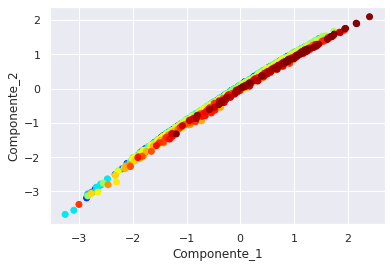

In [ ]:
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=0.001, min_samples = 1)
clusters = dbscan.fit_predict(X_scaled)

plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=clusters, cmap='jet')
plt.xlabel("Componente_1")
plt.ylabel("Componente_2")

Gaussian Mixture Models

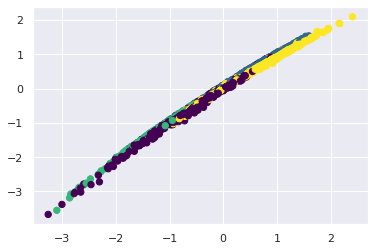

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
from sklearn import mixture
gmm = mixture.GaussianMixture(n_components=4).fit(X_scaled)
labels = gmm.predict(X_scaled)
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=labels, s=40, cmap='viridis');

[[0.    0.    1.    0.   ]
 [1.    0.    0.    0.   ]
 [0.001 0.    0.999 0.   ]
 [1.    0.    0.    0.   ]
 [0.    0.    1.    0.   ]
 [0.    0.    1.    0.   ]
 [0.    0.    1.    0.   ]
 [0.    0.    1.    0.   ]
 [1.    0.    0.    0.   ]
 [1.    0.    0.    0.   ]]


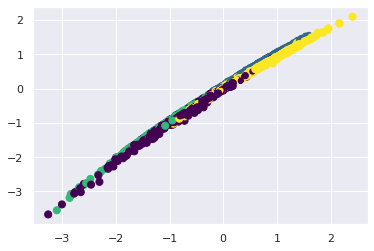

In [ ]:
probs = gmm.predict_proba(X_scaled)
print(probs[40:50].round(3))
size = 50 * probs.max(1) ** 2  # square emphasizes differences
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=labels, cmap='viridis', s=size);


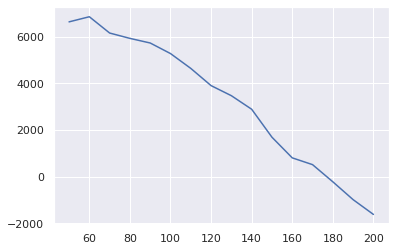

In [ ]:
n_components = np.arange(50, 210, 10)
models = [mixture.GaussianMixture(n, covariance_type='full', random_state=0)
          for n in n_components]
aics = [model.fit(X_scaled).aic(X_scaled) for model in models]
plt.plot(n_components, aics);

In [ ]:
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
        
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)